<a href="https://colab.research.google.com/github/benihime91/pytorch_examples/blob/master/object_detection_with_pytorch_lightning_using_FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Setup : 

- Download the `Oxford-IIIT Pet Dataset`[from here](https://www.robots.ox.ac.uk/~vgg/data/pets/).
- Save the `zip` file in `GoogleDrive` at a folder called Data.
- Run the cell below to load in `GoogleDrive`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Download the required libraries & untar the Data**

In [ ]:
%%shell

pip install -U pytorch-lightning bounding_box
pip install -U git+https://github.com/albumentations-team/albumentations
tar zxvf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/
git clone https://github.com/Erlemar/wheat.git

In [1]:
! nvidia-smi

Thu Aug 20 13:30:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Standard Imports :**

In [2]:
import os 
os.chdir('/content/wheat')

In [3]:
# Standard Imports
import warnings
import numpy as np
import re
import xml.etree.ElementTree as ET
from pathlib import Path

# General Utils
import cv2
from google.colab.patches import cv2_imshow
from bounding_box import bounding_box as bb
import matplotlib.pyplot as plt
import seaborn as sns

# Data Parsing / Processing
import pandas as pd
from sklearn import preprocessing, model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch Imports
import torch
import torch.nn as nn
from torch import optim

# PyTorch Lightning Imports
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# TorchVision Imports
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn


# COCO Eval Utils
from src.utils.coco_eval import CocoEvaluator
from src.utils.coco_utils import get_coco_api_from_dataset, _get_iou_types


pl.seed_everything(219)
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None, 'display.max_rows', None)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preprocessing :

In [4]:
## IMAGE PATHS

img_desc = Path('/content/oxford-iiit-pet/images')
annot_dir = Path("/content/oxford-iiit-pet/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]

In [5]:
def xml_to_csv(pths):
    """Extracts the filenames and the bboxes from the xml_list"""
    xml_list = []
    for xml_file in pths:
        # Read in the xml file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                value = (
                    # Extract the path to the image
                    str(img_desc/root.find("filename").text),
                    # Extract the bounding boxes
                    # 1. xmin
                    float(m[4][0].text),
                    # 2. ymin
                    float(m[4][1].text),
                    # 3. xmax
                    float(m[4][2].text),
                    # 4. ymax
                    float(m[4][3].text),
                )
                xml_list.append(value)
            except: pass
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [6]:
# --------------------------------------------------------------------------------------------------
# Fix Data
# --------------------------------------------------------------------------------------------------

df = xml_to_csv(annots)

pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)

# 1. Extract the label
df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]

# 2. Convert the classes to integers add +1 becaus0 is background class for `FasterRCNN`
le = preprocessing.LabelEncoder()
df["target"] = le.fit_transform(df["class"].values) + 1

# 3. Shuffle the dataFrame
df = df.sample(frac=1).reset_index(drop=True)

df.head()

filename  ...  target
0            /content/oxford-iiit-pet/images/wheaten_terrier_131.jpg  ...      36
1  /content/oxford-iiit-pet/images/american_pit_bull_terrier_125.jpg  ...       3
2             /content/oxford-iiit-pet/images/great_pyrenees_156.jpg  ...      16
3                  /content/oxford-iiit-pet/images/chihuahua_100.jpg  ...      11
4           /content/oxford-iiit-pet/images/scottish_terrier_177.jpg  ...      31

[5 rows x 7 columns]

In [7]:
print("Total Examples: ", len(df))
print("Toal number of Unique Examples", len(df['target'].unique()))

Total Examples:  3687
Toal number of Unique Examples 37


In [8]:
cls_names = df['class'].unique()
cls_idxs  = le.transform(cls_names) + 1
cls_dict  = {key:value for key,value in list(zip(list(cls_idxs), list(cls_names)))}
cls_dict

{1: 'abyssinian',
 2: 'american_bulldog',
 3: 'american_pit_bull_terrier',
 4: 'basset_hound',
 5: 'beagle',
 6: 'bengal',
 7: 'birman',
 8: 'bombay',
 9: 'boxer',
 10: 'british_shorthair',
 11: 'chihuahua',
 12: 'egyptian_mau',
 13: 'english_cocker_spaniel',
 14: 'english_setter',
 15: 'german_shorthaired',
 16: 'great_pyrenees',
 17: 'havanese',
 18: 'japanese_chin',
 19: 'keeshond',
 20: 'leonberger',
 21: 'maine_coon',
 22: 'miniature_pinscher',
 23: 'newfoundland',
 24: 'persian',
 25: 'pomeranian',
 26: 'pug',
 27: 'ragdoll',
 28: 'russian_blue',
 29: 'saint_bernard',
 30: 'samoyed',
 31: 'scottish_terrier',
 32: 'shiba_inu',
 33: 'siamese',
 34: 'sphynx',
 35: 'staffordshire_bull_terrier',
 36: 'wheaten_terrier',
 37: 'yorkshire_terrier'}

In [9]:
def display_image():
    
    "Display Images"
    
    im = cv2.imread(df.filename[0])
    bb.add(im, df.xmin[0], df.ymin[0], df.xmax[0], df.ymax[0], label=f'{df["class"][0]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[1])
    bb.add(im, df.xmin[1], df.ymin[1], df.xmax[1], df.ymax[1], label=f'{df["class"][1]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[3])
    bb.add(im, df.xmin[3], df.ymin[3], df.xmax[3], df.ymax[3], label=f'{df["class"][3]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[4])
    bb.add(im, df.xmin[4], df.ymin[4], df.xmax[4], df.ymax[4], label=f'{df["class"][4]}')
    cv2_imshow(im)

    im = cv2.imread(df.filename[10])
    bb.add(im, df.xmin[10], df.ymin[10], df.xmax[10], df.ymax[10], label=f'{df["class"][10]}')
    cv2_imshow(im)

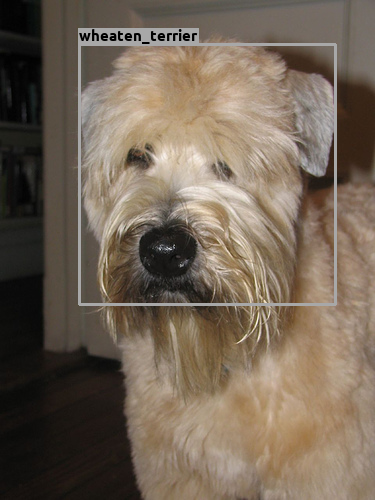

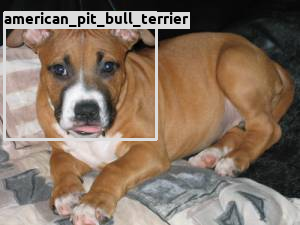

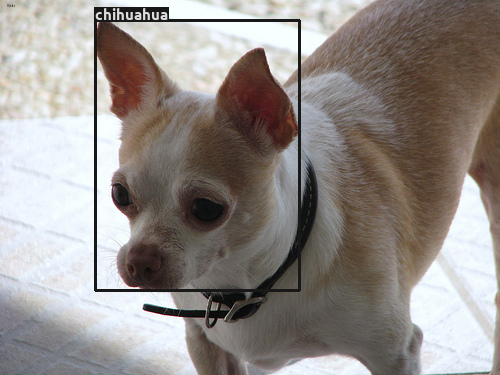

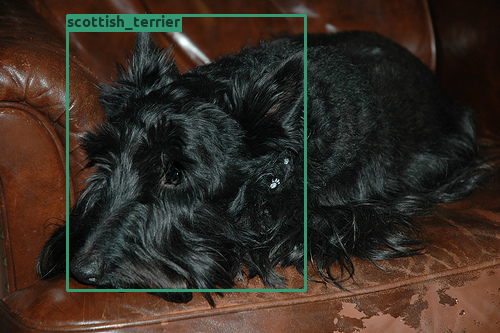

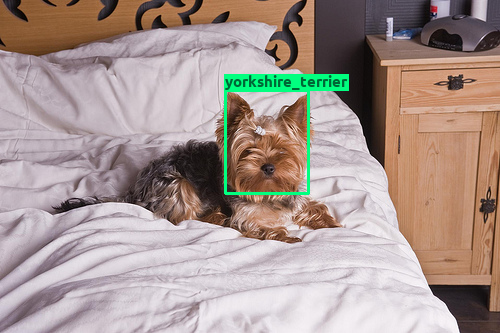

In [10]:
display_image()

In [11]:
df_train, df_test = model_selection.train_test_split(
    df, stratify=df['target'], test_size=0.25, shuffle=True
    )

df_train.reset_index(drop=True, inplace=True)
df_train.head()

filename  ...  target
0  /content/oxford-iiit-pet/images/english_cocker_spaniel_130.jpg  ...      13
1                 /content/oxford-iiit-pet/images/Ragdoll_141.jpg  ...      27
2                 /content/oxford-iiit-pet/images/Siamese_184.jpg  ...      33
3               /content/oxford-iiit-pet/images/Maine_Coon_17.jpg  ...      21
4           /content/oxford-iiit-pet/images/japanese_chin_155.jpg  ...      18

[5 rows x 7 columns]

In [12]:
df_test.reset_index(drop=True, inplace=True)
df_test.head()

filename  ...  target
0  /content/oxford-iiit-pet/images/British_Shorthair_207.jpg  ...      10
1           /content/oxford-iiit-pet/images/havanese_144.jpg  ...      17
2         /content/oxford-iiit-pet/images/Maine_Coon_112.jpg  ...      21
3       /content/oxford-iiit-pet/images/Russian_Blue_193.jpg  ...      28
4  /content/oxford-iiit-pet/images/yorkshire_terrier_185.jpg  ...      37

[5 rows x 7 columns]

In [13]:
print("No. of Training Examples: ",   len(df_train))
print("No. of Validation Examples: ", len(df_test)) 

No. of Training Examples:  2765
No. of Validation Examples:  922


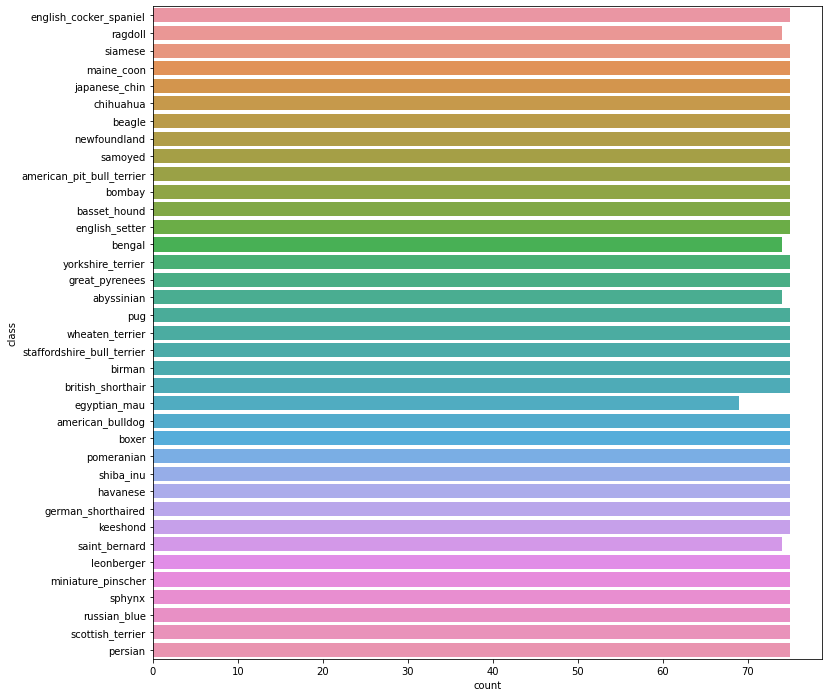

In [14]:
plt.figure(figsize=(12,12))
sns.countplot(y='class', data=df_train)

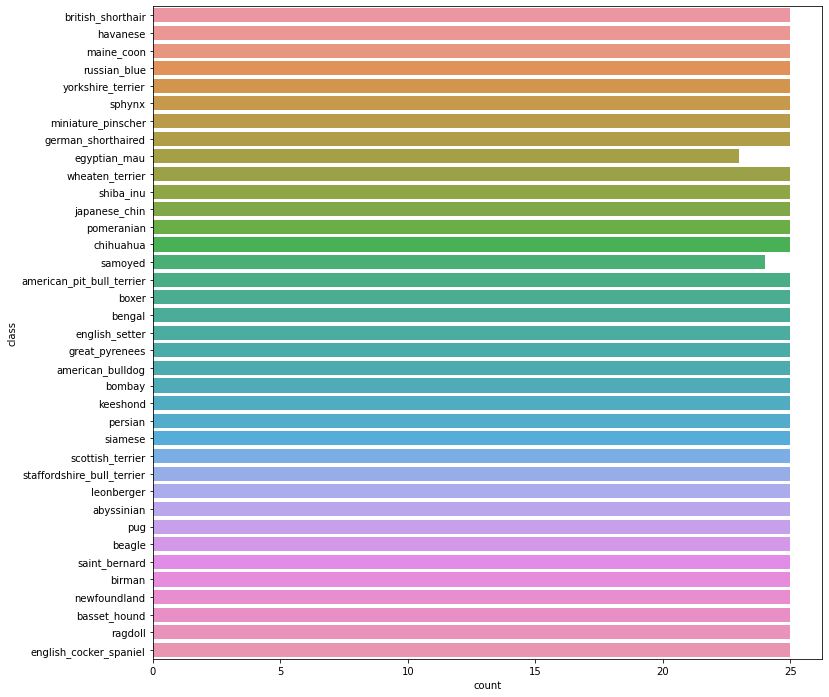

In [15]:
plt.figure(figsize=(12,12))
sns.countplot(y='class', data=df_test)

In [16]:
# --------------------------------------------------------------------------------------------------
# IMAGE TRANSFORMATIONS
# --------------------------------------------------------------------------------------------------

transformations = [
    A.HorizontalFlip(p=0.5),
    A.CLAHE(),
    A.IAASharpen(),
    A.IAAPerspective(),
    A.OneOf([
        A.ShiftScaleRotate(),
        A.Rotate(limit=60),
    ], p=1.0),
    A.OneOf([
        A.RandomShadow(),
        A.RandomBrightnessContrast(),
        A.Cutout()
    ], p=0.5)
]

# Train Transformations
train_transformations = transformations + [ A.ToFloat(max_value=255., always_apply=True), 
                                            ToTensorV2(always_apply=True) ]

# Valid Transformations
valid_transformations = [ A.ToFloat(max_value=255., always_apply=True), 
                          ToTensorV2(always_apply=True) ]

# Transformations:
transforms = {
    "train":A.Compose(train_transformations, p=1.0, bbox_params=A.BboxParams(format="pascal_voc", 
                                                                             label_fields=["class_labels"])),
              
    "valid": A.Compose(valid_transformations, p=1.0, bbox_params=A.BboxParams(format="pascal_voc", 
                                                                              label_fields=["class_labels"]))
    }

In [17]:
transforms

{'train': Compose([
   HorizontalFlip(always_apply=False, p=0.5),
   CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8)),
   IAASharpen(always_apply=False, p=0.5, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
   IAAPerspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True),
   OneOf([
     ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None),
     Rotate(always_apply=False, p=0.5, limit=(-60, 60), interpolation=1, border_mode=4, value=None, mask_value=None),
   ], p=1.0),
   OneOf([
     RandomShadow(always_apply=False, p=0.5, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5),
     RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
     Cutout(always_apply=False, p=0.5,

In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, train=False):
        self.df = dataframe
        self.image_ids = self.df["filename"]

        if train:
            self.tfms  = transforms['train']
        else:
            self.tfms  = transforms['valid']

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Grab the Image
        image_id = self.image_ids[idx]
        im       = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)

        # extract the bounding boxes
        records = self.df[self.df['filename'] == image_id]
        boxes   = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        # claculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Grab the Class Labels
        class_labels = records['target'].values.tolist()

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        # apply transformations
        transformed = self.tfms(image=im, bboxes=boxes, class_labels=class_labels)
        image = transformed["image"]
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        class_labels = torch.tensor(transformed["class_labels"])

        # target dictionary
        target = {}
        image_idx = torch.tensor([idx])
        target['image_id'] = image_idx
        target['boxes']    = boxes
        target['labels']   = class_labels
        target['area']     = area
        target['iscrowd']  = iscrowd

        return image, target, image_idx

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))


def disp_batch(batch) -> None:
    " funtion to display batch"
    image, target, _ = batch
    n = np.random.randint(0, len(image))
    im = image[n].permute(1, 2, 0).numpy()

    for boxes in target[n]["boxes"]:
        b = boxes.numpy()
        bb.add(im, b[0], b[1], b[2], b[3])
    cv2_imshow(np.array(im * 255., dtype=np.float32))

In [20]:
# Toy Batched for Sanity Check
BATCH_SIZE = 20

train_ds = Dataset(df_train, train=True)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_ds = Dataset(df_test, train=False)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

batch = next(iter(train_dl))
val_batch = next(iter(val_dl))

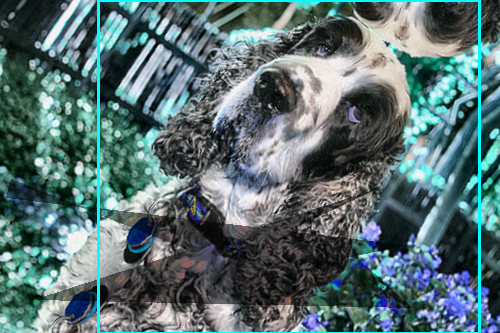

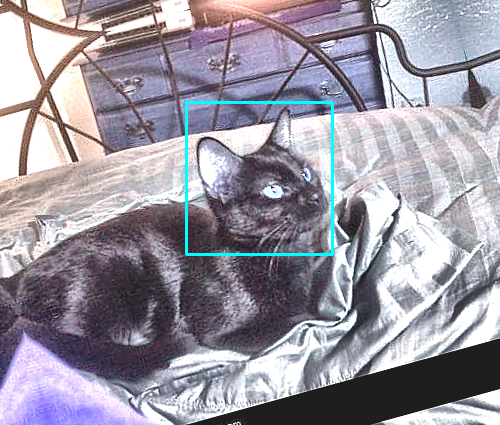

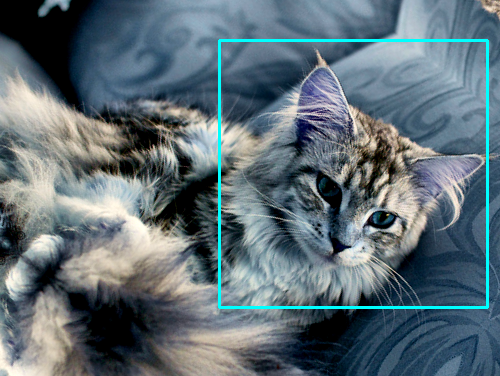

In [21]:
disp_batch(batch)
disp_batch(batch)
disp_batch(batch)

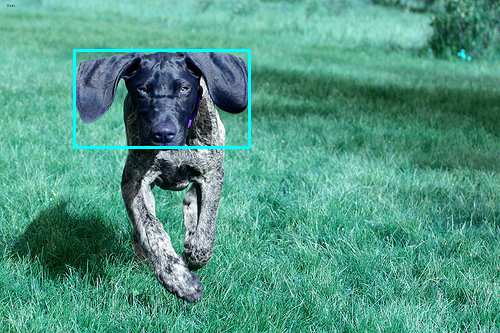

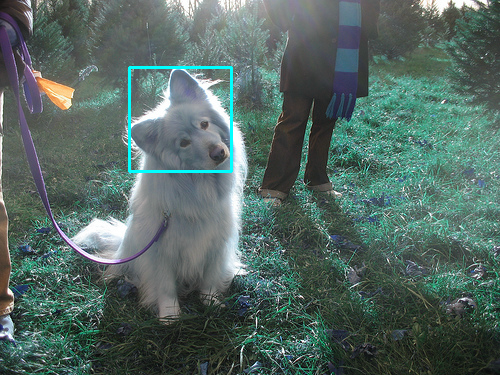

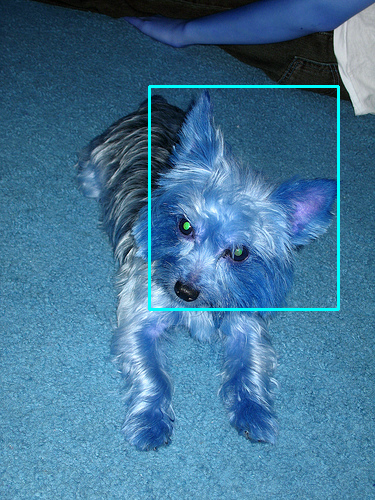

In [22]:
disp_batch(val_batch)
disp_batch(val_batch)
disp_batch(val_batch)

In [23]:
# Create `PyTorchLightning Module`

class LitModel(pl.LightningModule):
    def __init__(self,
                 model:nn.Module,
                 optimizer:optim,
                 train_dl:torch.utils.data.DataLoader,
                 val_dl:torch.utils.data.DataLoader,
                 max_lr:float,
                 scheduler:optim.lr_scheduler=None, 
                 ):
        
        super(LitModel, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.scheduler = scheduler
        self.max_lr = max_lr

    def configure_optimizers(self, *args, **kwargs):
        optimizer = self.optimizer
        if self.scheduler is not None:
            scheduler = self.scheduler
            return [optimizer], [scheduler]
        else:
            return [optimizer]

    def optimizer_step(self, *args, **kwargs):
        # warmup lr
        if self.trainer.global_step < 500:
            alpha = min(1., float(self.trainer.global_step + 1) / 500.)
            for pg in self.optimizer.param_groups:
                pg['lr'] = alpha * self.max_lr

        # update params
        optimizer.step()
        optimizer.zero_grad()

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def train_dataloader(self, *args, **kwargs):
        return self.train_dl

    def val_dataloader(self, *args, **kwargs):
        valid_loader = self.val_dl

        # Prepare COCO Evaluator
        coco = get_coco_api_from_dataset(valid_loader.dataset)
        iou_types = ["bbox"]
        self.coco_evaluator = CocoEvaluator(coco, iou_types)
        return valid_loader

    def training_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        # Separate Losses
        loss_dict = self.model(images, targets)
        # Total Loss
        losses = sum(loss for loss in loss_dict.values())
        return {'loss': losses, 'log': loss_dict, 'progress_bar': loss_dict}

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.coco_evaluator.update(res)
        
        return {}

    def validation_epoch_end(self, outputs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()

        # coco main metric
        metric = self.coco_evaluator.coco_eval['bbox'].stats[0]
        metric = torch.as_tensor(metric)
        tensorboard_logs = {'bbox_IOU': metric}
        return {'val_loss': metric, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

In [24]:
###################################### Training Configurations ############################################

# --------------------------------------------------------------------------------------------------
# Model
# --------------------------------------------------------------------------------------------------

# load a model pre-trained on COCO
model = fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 37 + 1  # 37 class + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Freeze `Backbone`
for param in model.backbone.parameters():
    param.requires_grad = False

# --------------------------------------------------------------------------------------------------
# Inputs
# --------------------------------------------------------------------------------------------------
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 12

# Train DataLoader
train_ds = Dataset(df_train, train=True)
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=TRAIN_BATCH_SIZE,
                                       shuffle=True,
                                       collate_fn=collate_fn,
                                       pin_memory=True)

# Valid DataLoader
val_ds = Dataset(df_test, train=False)
val_dl = torch.utils.data.DataLoader(val_ds, 
                                     batch_size=VALID_BATCH_SIZE,
                                     shuffle=False,
                                     collate_fn=collate_fn,
                                     pin_memory=True)


# --------------------------------------------------------------------------------------------------
# Training Options
# --------------------------------------------------------------------------------------------------
EPOCHS = 35
MAX_LR = 8e-03
WD = 1e-03

# Optimzier and LrScheduler
optimizer = optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=MAX_LR,
    momentum=0.9,
    weight_decay=WD)

lr_scheduler = {
    "scheduler": optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9),
    "step" : 'epoch' }


# --------------------------------------------------------------------------------------------------
# PyTorchLightning CallBacks
# --------------------------------------------------------------------------------------------------
tb_logger = TensorBoardLogger(save_dir="/content/logs")
# TensorBoard Logger

# CheckPoint Logger
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    "content/saved_models", 
    mode= "max",
    monitor = "bbox_IOU",
    save_top_k = 3)

# EarlyStopping Callback
early_stopping_callback = pl.callbacks.EarlyStopping(
    mode= 'max',
    monitor= "bbox_IOU",
    patience = 5)

In [25]:
lightning_model = LitModel(model, optimizer, train_dl, val_dl, max_lr = MAX_LR, scheduler=lr_scheduler)

trainer = pl.Trainer(logger=[tb_logger],
                     gradient_clip_val = 0.5,
                     checkpoint_callback=checkpoint_callback,
                     max_epochs=EPOCHS, 
                     precision=16,
                     gpus = 1,
                     num_sanity_val_steps=0, 
                     log_gpu_memory = 'all',
                     accumulate_grad_batches=5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [ ]:
trainer.fit(lightning_model)


  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

In [ ]:
import shutil
shutil.rmtree("/content/logs")

In [ ]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir "/content/logs"